Compare to P-Net:


|                         | accuracy | auc      | aupr     | f1       | precision | recall   |
|-------------------------|----------|----------|----------|----------|-----------|----------|
| P-net_ALL               | 0.838235 | 0.926789 | 0.878182 | 0.755556 | 0.750000  | 0.761194 |
| Logistic Regression_ALL | 0.833333 | 0.881904 | 0.808983 | 0.725806 | 0.789474  | 0.671642 |

In [1]:
%cd /mnt/home/zzhang/ceph/cancer-net

/mnt/ceph/users/zzhang/cancer-net


In [2]:
import pnet_utils
import time
import torch, torch_geometric.transforms as T, torch.nn.functional as F

In [3]:
dataset = pnet_utils.PnetDataSet(
    root="./data/prostate",
    name="prostate_graph_humanbase",
    #files={'graph_file': "global.geneSymbol.gz"},
    edge_tol=0.5,
    pre_transform=T.Compose([T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]))

In [4]:
dataset.split_index_by_file(
    train_fp="./data/prostate/splits/training_set_0.csv",
    valid_fp="./data/prostate/splits/validation_set.csv",
    test_fp="./data/prostate/splits/test_set.csv"
)

In [5]:
dataset

PnetDataset(len=1011, graph=prostate_graph_humanbase, num_edges=15080, edge_tol=0.50)

Check whether test indices are fixed. 

Should be `[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]`

In [6]:
dataset.test_idx[0:10]

[764, 865, 136, 968, 847, 155, 961, 998, 23, 112]

cuda
Epoch: 10, Loss: 0.461, Train Acc: 0.7963, Time lapsed: 14.7 s
valid Loss: 0.482, Acc: 0.7600
Epoch: 20, Loss: 0.449, Train Acc: 0.8137, Time lapsed: 14.6 s
valid Loss: 0.456, Acc: 0.8000
Epoch: 30, Loss: 0.436, Train Acc: 0.8063, Time lapsed: 14.9 s
valid Loss: 0.455, Acc: 0.7700
Epoch: 40, Loss: 0.435, Train Acc: 0.8263, Time lapsed: 15.1 s
valid Loss: 0.448, Acc: 0.7700
Epoch: 50, Loss: 0.436, Train Acc: 0.8187, Time lapsed: 15.9 s
valid Loss: 0.438, Acc: 0.8200
Epoch: 60, Loss: 0.437, Train Acc: 0.8213, Time lapsed: 15.2 s
valid Loss: 0.441, Acc: 0.8200
Epoch: 70, Loss: 0.408, Train Acc: 0.8313, Time lapsed: 14.7 s
valid Loss: 0.438, Acc: 0.8300
Epoch: 80, Loss: 0.428, Train Acc: 0.8225, Time lapsed: 14.9 s
valid Loss: 0.443, Acc: 0.8100
Epoch: 90, Loss: 0.419, Train Acc: 0.8213, Time lapsed: 14.9 s
valid Loss: 0.425, Acc: 0.8300
Epoch: 100, Loss: 0.41, Train Acc: 0.8200, Time lapsed: 14.8 s
valid Loss: 0.429, Acc: 0.8400
Epoch: 110, Loss: 0.439, Train Acc: 0.8213, Time lapsed

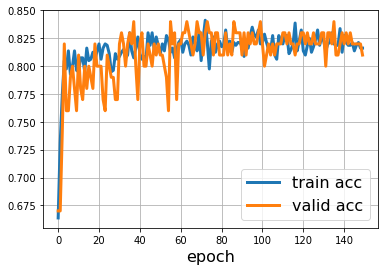

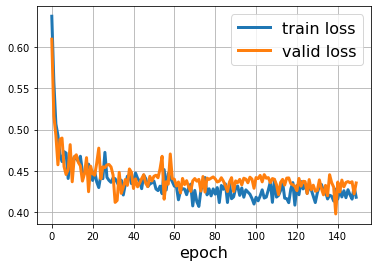

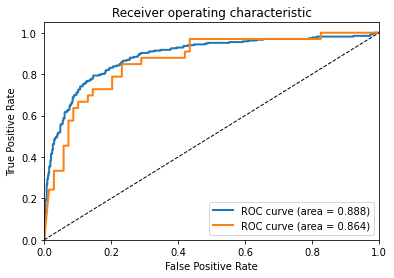

In [9]:
# Train using GCN/GCN2 architecture

# Hyperparameters etc:

arch = "GCN"
batch = 10
parall = False
lr = 0.01


import sys
import matplotlib.pyplot as plt, numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score
from torch_geometric.loader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%run arch/net

if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = "cpu"

print(device)

# prep data
train_loader = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=True,
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=True,
)

# get model
if arch == 'GCN2': # what is adj_t ??
    model = GCN2Net(
        hidden_channels=64,
        dim=3,
        num_layers=4,
        alpha=0.5,
        theta=1.0,
        shared_weights=False,
        dropout=0.2,
    ).to(device)
elif arch == 'GCN':
    model = GCNNet(dims=[3, 64, 256, 128]).to(device)

# training configs
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = F.nll_loss

t0 = time.time()
def train(epoch, report=True, progbar=False):
    model.train()
    global t0
    if epoch == 30:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr * 0.5

    if epoch == 60:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr * 0.1
            
    total_loss = 0
    correct = 0
    num_samps = 0
    gen = tqdm.tqdm(train_loader) if progbar is True else train_loader
    for data in gen:
        if not parall:
            data = data.to(device)
        optimizer.zero_grad()

        output = model(data)
        output = output.squeeze()

        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y

        if len(output.shape) == 1:
            output = output.unsqueeze(0)
        loss = criterion(output, y)

        pred = output.max(1)[1]
        correct += pred.eq(y).sum().item()
        total_loss += loss * batch
        loss.backward()
        optimizer.step()
        num_samps += len(y)
    if report:
        print(
            "Epoch: {:02d}, Loss: {:.3g}, Train Acc: {:.4f}, Time lapsed: {:.1f} s".format(
                epoch, total_loss / num_samps, correct / num_samps,
                time.time() - t0
            )
        )
        t0 = time.time()

    return total_loss / num_samps, correct / num_samps


def valid():
    model.eval()
    correct = 0

    total_loss = 0
    num_samps = 0
    for data in valid_loader:
        if not parall:
            data = data.to(device)
        output = model(data)
        output = output.squeeze()

        pred = output.max(1)[1]
        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y
        loss = criterion(output, y)
        total_loss += loss.item() * batch

        correct += pred.eq(y).sum().item()
        num_samps += len(y)
    return total_loss / num_samps, correct / num_samps


# run training
train_losses = []
train_acces = []
valid_acces = []
valid_losses = []
for epoch in range(1, 151):
    report = (epoch) % 10 == 0
    train_loss, train_acc = train(epoch, report=report)
    valid_loss, valid_acc = valid()
    train_losses.append(train_loss.cpu().detach().numpy())
    valid_losses.append(valid_loss)
    train_acces.append(train_acc)
    valid_acces.append(valid_acc)
    if report:
        print("valid Loss: {:.3g}, Acc: {:.4f}".format(valid_loss, valid_acc))

# vis training traj
plt.figure()
plt.plot(train_acces, label="train acc", linewidth=3)
plt.plot(valid_acces, label="valid acc", linewidth=3)
plt.legend(prop={"size": 16})
plt.xlabel("epoch", fontsize=16)
plt.grid()
plt.show()
plt.plot(train_losses, c="tab:blue", label="train loss", linewidth=3)
plt.plot(valid_losses, c="tab:orange", label="valid loss", linewidth=3)
plt.legend(prop={"size": 16})
plt.xlabel("epoch", fontsize=16)
plt.grid()
plt.show()

# vis training + validation metrics
loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_train, tpr_train, _ = roc_curve(ys, outs[:, 1])
train_auc = auc(fpr_train, tpr_train)

loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_valid, tpr_valid, _ = roc_curve(ys, outs[:, 1])
valid_auc = auc(fpr_valid, tpr_valid)

plt.plot(
    fpr_train, tpr_train, lw=2, label="ROC curve (area = %0.3f)" % train_auc,
)
plt.plot(
    fpr_valid, tpr_valid, lw=2, label="ROC curve (area = %0.3f)" % valid_auc,
)
plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()


In [10]:
# testing performance
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, f1_score, accuracy_score, \
    precision_score, recall_score

loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_valid, tpr_valid, _ = roc_curve(ys, outs[:, 1])
test_auc = auc(fpr_valid, tpr_valid)

print('accuracy', accuracy_score(ys, outs[:, 1]>0.5))
print('auc', test_auc)
print('aupr', average_precision_score(ys, outs[:, 1]))
print('f1', f1_score(ys, outs[:, 1]>0.5))
print('precision', precision_score(ys, outs[:, 1]>0.5))
print('recall', recall_score(ys, outs[:, 1]>0.5))


accuracy 0.8627450980392157
auc 0.9212802768166091
aupr 0.866870213185597
f1 0.7741935483870968
precision 0.8571428571428571
recall 0.7058823529411765
